# 🔫 Predicting Gun Involvement in Crime Events (Chicago Crime Dataset)

This notebook trains and evaluates machine learning models to predict whether an ongoing crime in Chicago involves a firearm.  
We use **temporal**, **geographic**, and **location-based** features from the **Chicago Crime Dataset** (2016–2025).  
The task is a **binary classification** problem, comparing **Random Forest** and **Linear SVM** classifiers.


## 📂 Dataset Description
- **Source:** [Chicago Crime Dataset (2001–Present)](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/about_data)
- **Subset Used:** 2016–2025 crimes (~500,000 entries), balanced 50% firearm / 50% no firearm via undersampling.
- **Features Used:**
  - **Temporal:** Hour of day, day of week
  - **Geographic:** Latitude, Longitude
  - **Categorical:** Primary Type, Location Description
- **Target Variable:** Presence of a firearm (regex on `Description` field).


In [ ]:
#load new data
df = pd.read_csv('2016-2025 CrimesChicago.csv')

## 🛠 Data Preprocessing Steps
1. Extract `hour_of_day` and `day_of_week` from the Date column.
2. Keep Latitude and Longitude as numeric features.
3. One-hot encode categorical variables (`Primary Type`, `Location Description`).
4. Use regex to label firearm presence in `Description`.
5. Remove rows with missing values.
6. Randomly undersample the majority class for a balanced dataset.


              precision    recall  f1-score   support

           0       0.90      0.86      0.88     45883
           1       0.87      0.90      0.88     46283

    accuracy                           0.88     92166
   macro avg       0.88      0.88      0.88     92166
weighted avg       0.88      0.88      0.88     92166

Balanced Accuracy: 0.8818


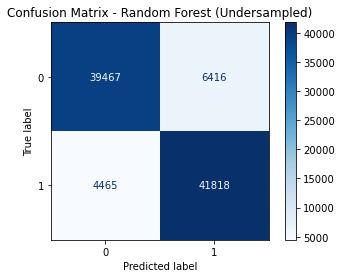

Prediction (1 = 'weapon' mentioned): 1


In [ ]:
# Random forest + undersampling

#random forest with undersampling ( larger dataset)
weapon_keywords = r"\b(?:gun|handgun|firearm|pistol|revolver|rifle|semi-automatic|shotgun|weapon|automatic weapon|fire arms)\b"
df['weapon_mentioned'] = df['Description'].str.contains(weapon_keywords, case=False, na=False, regex=True).astype(int)


# parse date into separate features
df['datetime'] = pd.to_datetime(df['Date'], errors='coerce')
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

# features
features = ['Primary Type', 'Location Description', 'Latitude', 'Longitude', 'hour', 'dayofweek']
df = df.dropna(subset=features + ['weapon_mentioned'])  # Ensure no missing data
X_full = df[features]
y_full = df['weapon_mentioned']



# combine X and y for resampling
df_combined = df[features + ['weapon_mentioned']]

# split by class
df_majority = df_combined[df_combined['weapon_mentioned'] == 0]
df_minority = df_combined[df_combined['weapon_mentioned'] == 1]

# downsample majority to match minority count
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)


df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#redefine features
X = df_balanced[features]
y = df_balanced['weapon_mentioned']



# Preprocessing
categorical_features = ['Primary Type', 'Location Description']
numerical_features = ['Latitude', 'Longitude', 'hour', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train
pipeline.fit(X_train, y_train)

# evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Undersampled)")
plt.show()

# Test example
example = pd.DataFrame([{
    'Primary Type': 'ASSAULT',
    'Location Description': 'STREET',
    'Latitude': 41.8781,
    'Longitude': -87.6298,
    'hour': 22,
    'dayofweek': 0  # Monday
}])

print("Prediction (1 = 'weapon' mentioned):", pipeline.predict(example)[0])

In [ ]:
# Total samples
print(f"Total samples: {len(df)}")

# Distribution of target classes
print(df['weapon_mentioned'].value_counts())

# Optional: Percentages
print(df['weapon_mentioned'].value_counts(normalize=True) * 100)

No‐weapon samples: 2087747
Weapon‐mentioned samples: 230852
[LibLinear]iter  1 act 2.437e+05 pre 2.419e+05 delta 2.604e+00 f 3.687e+05 |g| 2.343e+05 CG   7
iter  2 act 6.405e+03 pre 5.630e+03 delta 2.604e+00 f 1.249e+05 |g| 2.043e+04 CG  14
iter  3 act 1.515e+03 pre 1.316e+03 delta 2.604e+00 f 1.185e+05 |g| 6.004e+03 CG  17
iter  4 act 3.142e+02 pre 2.796e+02 delta 2.604e+00 f 1.170e+05 |g| 2.088e+03 CG  19
iter  5 act 7.858e+01 pre 7.046e+01 delta 2.604e+00 f 1.167e+05 |g| 7.252e+02 CG  25
iter  6 act 2.114e+01 pre 1.879e+01 delta 2.604e+00 f 1.166e+05 |g| 3.589e+02 CG  33
iter  7 act 1.096e+01 pre 8.585e+00 delta 2.604e+00 f 1.166e+05 |g| 1.682e+02 CG  54
iter  8 act 1.366e+01 pre 1.012e+01 delta 2.604e+00 f 1.166e+05 |g| 1.126e+02 CG  45
cg reaches trust region boundary
iter  9 act 1.807e+01 pre 1.612e+01 delta 2.982e+00 f 1.166e+05 |g| 5.061e+01 CG  39
iter 10 act -8.126e+01 pre 6.865e+00 delta 5.560e-01 f 1.165e+05 |g| 7.151e+01 CG 117
cg reaches trust region boundary
iter 10 act 

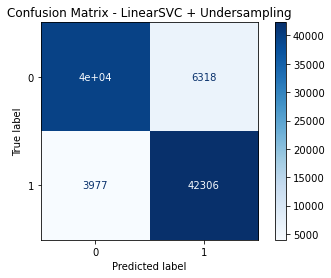

In [ ]:
# Linear SVM + unersampling
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

# load data starting 2016
df = pd.read_csv('2016-2025 CrimesChicago.csv')

weapon_keywords = r"\b(?:gun|handgun|firearm|pistol|revolver|rifle|semi-automatic|shotgun|weapon|automatic weapon|fire arms)\b"
df['weapon_mentioned'] = df['Description'].str.contains(weapon_keywords, case=False, na=False, regex=True).astype(int)

# count before undersampling
counts = df['weapon_mentioned'].value_counts()
print(f"No‐weapon samples: {counts.get(0,0)}")
print(f"Weapon‐mentioned samples: {counts.get(1,0)}")

df['datetime'] = pd.to_datetime(df['Date'], errors='coerce')
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

#clean data, select featutes
features = ['Primary Type', 'Location Description', 'Latitude', 'Longitude', 'hour', 'dayofweek']
df = df.dropna(subset=features + ['weapon_mentioned'])

#undersampling ( dropping no gun samples)
df_majority = df[df['weapon_mentioned'] == 0]
df_minority = df[df['weapon_mentioned'] == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[features]
y = df_balanced['weapon_mentioned']

# preprocessing
categorical_features = ['Primary Type', 'Location Description']
numerical_features = ['Latitude', 'Longitude', 'hour', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        C=1.0,
        class_weight='balanced',
        dual=False,
        max_iter=10000,
        verbose=1
    ))
])

# just to keep track of time
start = time.time()
pipeline.fit(X_train, y_train)
end = time.time()
print(f"\nTraining took {end - start:.2f} seconds\n")

# evaluation
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LinearSVC + Undersampling")
plt.show()

